# Instalacja pakietów

In [1]:
!pip install transformers datasets torch sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Załadowanie datasetu

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset("sms_spam")

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Dataset sms_spam downloaded and prepared to /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset['train'][123]

{'sms': 'Todays Voda numbers ending 7548 are selected to receive a $350 award. If you have a match please call 08712300220 quoting claim code 4041 standard rates app\n',
 'label': 1}

# Modyfikacja datasetu - klasyfikacja zero-shot

In [5]:
parsed_dataset = []

for row in dataset['train']:
  text = "Answer the question in one word - true if provided text is spam or false, if provided text is not spam.\n Q: Is this text spam? \nText: " + row['sms'] + "A: "
  new_row = {}
  new_row['sms'] = text
  if row['label'] == 0:
    new_row['label'] = "true"
  else:
    new_row['label'] = "false"
  parsed_dataset.append(new_row)

parsed_dataset[0]

{'sms': 'Answer the question in one word - true if provided text is spam or false, if provided text is not spam.\n Q: Is this text spam? \nText: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\nA: ',
 'label': 'true'}

# Tokenizer FLAN-T5

In [6]:
from transformers import AutoTokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base')

In [8]:
sms = parsed_dataset[0]['sms']
print('Original: \n', sms)
print('Tokenized: ', tokenizer.tokenize(sms))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sms)))

Original: 
 Answer the question in one word - true if provided text is spam or false, if provided text is not spam.
 Q: Is this text spam? 
Text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
A: 
Tokenized:  ['▁Answer', '▁the', '▁question', '▁in', '▁one', '▁word', '▁', '-', '▁true', '▁', 'if', '▁provided', '▁text', '▁is', '▁spam', '▁or', '▁false', ',', '▁', 'if', '▁provided', '▁text', '▁is', '▁not', '▁spam', '.', '▁Q', ':', '▁I', 's', '▁this', '▁text', '▁spam', '?', '▁Text', ':', '▁Go', '▁until', '▁jur', 'ong', '▁point', ',', '▁crazy', '.', '.', '▁Available', '▁only', '▁in', '▁bug', 'is', '▁', 'n', '▁great', '▁world', '▁la', '▁', 'e', '▁buffet', '...', '▁Cine', '▁there', '▁got', '▁', 'a', 'more', '▁wa', 't', '...', '▁A', ':', '▁']
Token IDs:  [11801, 8, 822, 16, 80, 1448, 3, 18, 1176, 3, 99, 937, 1499, 19, 13655, 42, 6136, 6, 3, 99, 937, 1499, 19, 59, 13655, 5, 1593, 10, 27, 7, 48, 1499, 13655, 58, 5027, 10, 1263, 552, 1

# Check maximum lenght of a sentence

In [12]:
max_len = 0

for sentence in parsed_dataset:
    input_ids = tokenizer.encode(sentence['sms'], add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  377


In [13]:
max_label_len = 0

for sentence in parsed_dataset:
    input_ids = tokenizer.encode(sentence['label'], add_special_tokens=True)
    max_label_len = max(max_label_len, len(input_ids))

print('Max sentence length: ', max_label_len)

Max sentence length:  2


# Pre train tokenization

In [11]:
import torch

In [14]:
input_ids = []
target_ids = []
attention_masks = []

for sentence in parsed_dataset:
    encoded_dict = tokenizer.encode_plus(
                        sentence['sms'],
                        add_special_tokens = True,
                        max_length = 380,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    encoded_target_dict = tokenizer.encode_plus(
                        sentence['label'],
                        add_special_tokens = True,
                        max_length = 2,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    target_ids.append(encoded_target_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
target_ids = torch.cat(target_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

print('Original: ', parsed_dataset[0])
print('Token IDs:', input_ids[0])
print('Label token IDs:', target_ids[0])

Original:  {'sms': 'Answer the question in one word - true if provided text is spam or false, if provided text is not spam.\n Q: Is this text spam? \nText: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\nA: ', 'label': 'true'}
Token IDs: tensor([11801,     8,   822,    16,    80,  1448,     3,    18,  1176,     3,
           99,   937,  1499,    19, 13655,    42,  6136,     6,     3,    99,
          937,  1499,    19,    59, 13655,     5,  1593,    10,    27,     7,
           48,  1499, 13655,    58,  5027,    10,  1263,   552, 10081,  2444,
          500,     6,  6139,     5,     5,  8144,   163,    16,  8143,   159,
            3,    29,   248,   296,    50,     3,    15, 15385,   233, 17270,
          132,   530,     3,     9,  3706,  8036,    17,   233,    71,    10,
            3,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,   

# Split dataset

In [15]:
from torch.utils.data import TensorDataset, random_split

In [16]:
dataset = TensorDataset(input_ids, attention_masks, target_ids)

test_size = 1000
dataset_len = len(dataset)
train_size = int(0.9 * (dataset_len-test_size))
val_size = (dataset_len-test_size) - train_size

test_dataset, train_dataset, val_dataset = random_split(dataset, [test_size, train_size, val_size])

print('{:>5,} test samples'.format(test_size))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,000 test samples
4,116 training samples
  458 validation samples


# Create train and validation loaders

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [18]:
batch_size = 8

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# Device check

In [19]:
if torch.cuda.is_available():    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Load FLAN-T5 model

In [20]:
from transformers import AutoModelForSeq2SeqLM

In [21]:
model = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base')

model.cuda()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

# Helper functions

In [22]:
import datetime
import numpy as np

In [23]:
def calculate_accuracy(preds, target):
  results_ok = 0.0
  results_false = 0.0

  for idx, pred in enumerate(preds):
    if pred == target[idx]:
      results_ok += 1.0
    else:
      results_false += 1.0

  return results_ok / (results_ok + results_false)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Init training

In [24]:
from transformers import get_linear_schedule_with_warmup

In [25]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-4,
                  eps = 1e-8
                )

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Training

In [26]:
import random
import time

In [27]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    total_train_acc = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        y = batch[2].to(device)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100

        model.zero_grad()        

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            decoder_input_ids=y_ids,
            labels=lm_labels
        )

        generated_ids = model.generate(
            input_ids = b_input_ids,
            attention_mask = b_input_mask, 
            max_length=2, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in y]
        total_train_acc += calculate_accuracy(preds, target)   

        loss = outputs['loss']
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    avg_train_acc = total_train_acc / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Average training acc: {0:.2f}".format(avg_train_acc))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    total_eval_accuracy = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        y = batch[2].to(device)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        
        with torch.no_grad():        

          outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            decoder_input_ids=y_ids,
            labels=lm_labels
          )

          loss = outputs['loss']
          total_eval_loss += loss.item()

          generated_ids = model.generate(
            input_ids = b_input_ids,
            attention_mask = b_input_mask, 
            max_length=2, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
          )

          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in y]
          total_eval_accuracy += calculate_accuracy(preds, target)        

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    validation_time = format_time(time.time() - t0)
    print("  Validation took: {:}".format(validation_time))
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': avg_train_acc,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    515.    Elapsed: 0:00:46.
  Batch    80  of    515.    Elapsed: 0:01:30.
  Batch   120  of    515.    Elapsed: 0:02:14.
  Batch   160  of    515.    Elapsed: 0:02:59.
  Batch   200  of    515.    Elapsed: 0:03:44.
  Batch   240  of    515.    Elapsed: 0:04:28.
  Batch   280  of    515.    Elapsed: 0:05:13.
  Batch   320  of    515.    Elapsed: 0:05:57.
  Batch   360  of    515.    Elapsed: 0:06:42.
  Batch   400  of    515.    Elapsed: 0:07:26.
  Batch   440  of    515.    Elapsed: 0:08:11.
  Batch   480  of    515.    Elapsed: 0:08:55.

  Average training loss: 0.01
  Average training acc: 0.59
  Training epcoh took: 0:09:34

Running Validation...
  Accuracy: 0.47
  Validation took: 0:00:31
  Validation Loss: 0.00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    515.    Elapsed: 0:00:44.
  Batch    80  of    515.    Elapsed: 0:01:29.
  Batch   120  of    515.    Elapsed: 0:02:13.
  Batch   160  of    515.  

# Train summary

In [28]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')
df_stats

Training Loss  Training Accur.  Valid. Loss  Valid. Accur.  \
epoch                                                               
1           5.27e-03             0.59          0.0           0.47   
2           2.74e-08             0.59          0.0           0.46   
3           1.58e-08             0.59          0.0           0.46   
4           1.55e-08             0.58          0.0           0.46   

      Training Time Validation Time  
epoch                                
1           0:09:34         0:00:31  
2           0:09:32         0:00:31  
3           0:09:39         0:00:31  
4           0:09:32         0:00:31

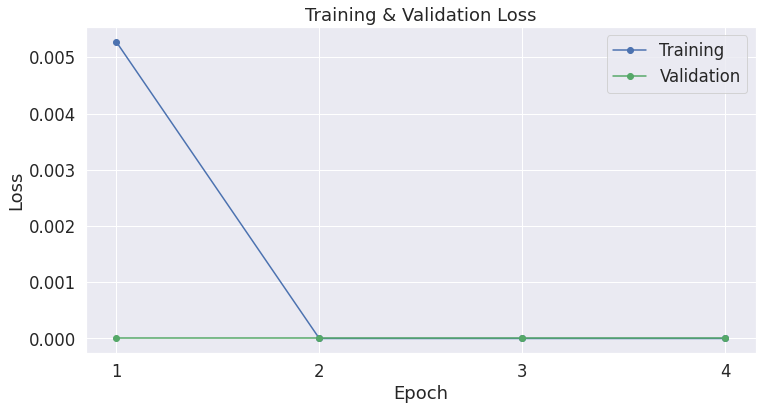

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Create test loader

In [30]:
prediction_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

# Evaluate on test dataset

In [31]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    y = batch[2].to(device)
    
    with torch.no_grad():        

      generated_ids = model.generate(
        input_ids = b_input_ids,
        attention_mask = b_input_mask, 
        max_length=2, 
        num_beams=2,
        repetition_penalty=2.5, 
        length_penalty=1.0, 
        early_stopping=True
      )
        
    preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
    target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in y]

    predictions.append(preds)
    true_labels.append(target)

print('    DONE.')

Predicting labels for 1,000 test sentences...
    DONE.


In [32]:
results_ok = 0
results_false = 0
for idx, true_labels_batch in enumerate(true_labels):
  for bidx, true_label in enumerate(true_labels_batch):
    if true_label == predictions[idx][bidx]:
      results_ok += 1
    else:
      results_false += 1

print("Correct predictions: {}, incorrect results: {}, accuracy: {}".format(results_ok, results_false, float(results_ok) / (results_ok + results_false)))

Correct predictions: 431, incorrect results: 569, accuracy: 0.431


In [ ]:
print("Sample prediction: {}, expected: {}".format(predictions[2][0], true_labels[2][0]))

Sample prediction: I, expected: true


# MCC Score

In [33]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i], predictions[i])                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


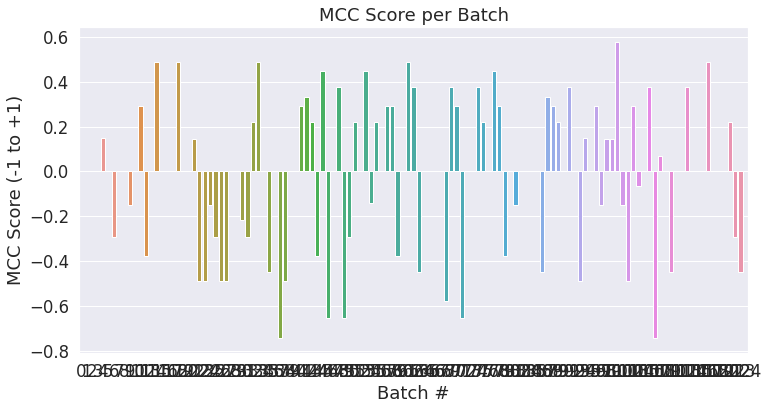

In [34]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [35]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

Total MCC: -0.033


# Save model

In [36]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

output_dir = '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/FLAN-T5_Model'
print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Mounted at /content/gdrive/
Saving model to /content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/FLAN-T5_Model


('/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/FLAN-T5_Model/tokenizer_config.json',
 '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/FLAN-T5_Model/special_tokens_map.json',
 '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/FLAN-T5_Model/spiece.model',
 '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/FLAN-T5_Model/added_tokens.json',
 '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/FLAN-T5_Model/tokenizer.json')

# Bibliografia
- https://huggingface.co/docs/transformers/main/en/model_doc/flan-t5
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/#a1-saving--loading-fine-tuned-model
- https://huggingface.co/docs/transformers/model_doc/t5#training